### import packages

In [88]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import joblib

from eda_tables import explore
import ML_modelling as ml

## load prepared file

In [89]:
df = pd.read_csv('data/merged_train.csv')

df['target'] = df['target'].astype(int)
df['creation_date'] = pd.to_datetime(df['creation_date'])

df['day'] = df['day'].astype(int)
df['month'] = df['month'].astype(int)
df['year'] = df['year'].astype(int)
df['date_int'] = df[['date_int']].astype(int)

In [ ]:
#first info
explore(df)

## split data into X and y, scale and one-hot-encode

In [ ]:
X= df.drop(columns=['target', 'client_id','creation_date' ]).copy()
y = df['target']

# Select only numerical columns
numerical_cols = ['CL_1', 'CL_2', 'CL_3', 'CL_4',
                  'inc_CL_1_rel', 'inc_CL_2_rel', 'inc_CL_3_rel', 'inc_CL_4_rel',
                  'large_diff_CL_1_rel', 'large_diff_CL_2_rel', 'large_diff_CL_3_rel','large_diff_CL_4_rel',
                  'no_invoices','day', 'month', 'year', 'date_int']
categorical_cols = ['district', 'client_catg', 'region'] 

# these are boolean. no need to convert to category: 
# ('inc_CL_1','inc_CL_2', 'inc_CL_3', 'inc_CL_4','large_diff_CL_1','large_diff_CL_2', 'large_diff_CL_3', 'large_diff_CL_4')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)


# OneHotEncoder and StandardScaler
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols)  
])

# Fit and transform training data
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Convert back to DataFrame with correct column names
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(ohe_feature_names)

X_train_encoded = pd.DataFrame(X_train_encoded, columns=all_feature_names, index=X_train.index)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=all_feature_names, index=X_test.index)

#print("Encoded Training DataFrame: \n", X_train_encoded)
#print("\nEncoded Testing DataFrame: \n", X_test_encoded)

joblib.dump(preprocessor, "pretrained_models/preprocessor.pkl")

['pretrained_models/preprocessor.pkl']

# XGBOOST

### Baseline Model

In [73]:
model = XGBClassifier(random_state=42)
model.fit(X_train_encoded, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     25546
           1       0.31      0.02      0.03      1511

    accuracy                           0.94     27057
   macro avg       0.63      0.51      0.50     27057
weighted avg       0.91      0.94      0.92     27057

AUC:  0.7514132769823922


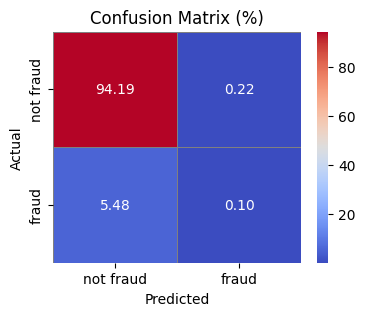

In [74]:
# predict
y_pred = model.predict(X_test_encoded)

print("Classification Report:\n", classification_report(y_test, y_pred))

y_probs = model.predict_proba(X_test_encoded)[:, 1]
auc = roc_auc_score(y_test, y_probs)

print("AUC: ", auc)

# confusion matrix
ml.plot_confusion_matrix(y_test, y_pred, labels=["not fraud", "fraud"])

### Full model 1

In [ ]:
param = {
    'n_estimators': [50, 100, 200, 250, 300, 500],
    'max_depth': [3, 5, 7, 9, 12, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 0.15, 0.2],
    'reg_lambda': [0.1, 1.0, 10.0]
}

model = XGBClassifier(random_state=42)
best_params_model = GridSearchCV(estimator=model, param_grid=param, scoring='f1', cv=5, verbose=2, n_jobs=-1)
#best_params_model = RandomizedSearchCV(estimator=model, param_distributions=param, scoring='f1', n_iter=150, 
#                                       cv=5, verbose=2, n_jobs=-1, random_state=42)

In [83]:
#train
best_params_model.fit(X_train_encoded, y_train)
print("Best parameters found: ", best_params_model.best_params_)
best_model = best_params_model.best_estimator_
joblib.dump(best_model, "pretrained_models/best_xgb_model.pkl")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:  {'colsample_bytree': 1.0, 'gamma': 0.3, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 250, 'reg_alpha': 0.01, 'reg_lambda': 10.0, 'subsample': 0.8}


['pretrained_models/best_xgb_model.pkl']

F1 Score: 0.01


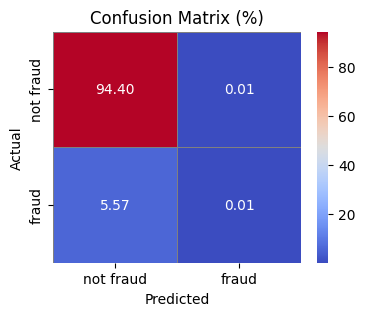

In [84]:
#predict 
best_model = joblib.load("pretrained_models/best_xgb_model.pkl")
y_pred = best_model.predict(X_test_encoded)
f_score = f1_score(y_test, y_pred)

print("F1 Score:", round(f_score,2))
ml.plot_confusion_matrix(y_test, y_pred, labels=["not fraud", "fraud"])

In [91]:
#best threshold for max f1
best_threshold = ml.best_threshold_for_metric(X_test_encoded, y_test, best_model, metric='f1')

print(f"Best threshold: {best_threshold}") 

# save threshold as pkl
joblib.dump(best_threshold, "pretrained_models/best_threshold.pkl")

Best threshold: 0.12699665129184723


['pretrained_models/best_threshold.pkl']

AUC:
 0.7698130798218011 

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     25546
           1       0.20      0.35      0.25      1511

    accuracy                           0.89     27057
   macro avg       0.58      0.63      0.60     27057
weighted avg       0.92      0.89      0.90     27057



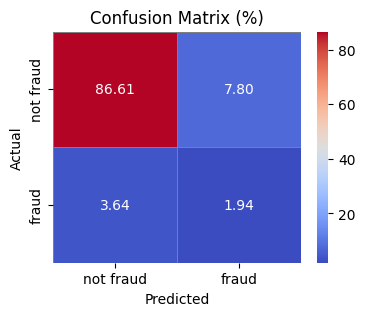

In [87]:
# Use the best threshold to make final predictions
y_pred_best, auc = ml.final_pred(best_model, X_test_encoded, y_test, best_threshold)
AUC_XGB = auc
ml.plot_confusion_matrix(y_test, y_pred_best, labels=["not fraud", "fraud"])

### Full model 2 with SMOTE

In [ ]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)

# Fit SMOTE to the training data and create a balanced dataset
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_encoded, y_train)

In [ ]:
#optimum parameters for f1

# Define the parameter grid
params = {
    'n_estimators': [50, 100, 200, 250, 300, 500],
    'max_depth': [3, 5, 7, 9, 12, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 0.15, 0.2],
    'reg_lambda': [0.1, 1.0, 10.0]
}

model = XGBClassifier(random_state=42)
#best_params_model = GridSearchCV(estimator=model, param_grid=param, scoring='f1', cv=5, verbose=2, n_jobs=-1)
best_params_model = RandomizedSearchCV(estimator=model, param_distributions=params, scoring='f1', n_iter=100, 
                                       cv=5, verbose=2, n_jobs=-1, random_state=42)

In [ ]:
#train
best_params_model.fit(X_train_balanced, y_train_balanced)
print("Best parameters found: ", best_params_model.best_params_)
best_model = best_params_model.best_estimator_
joblib.dump(best_model, "pretrained_models/best_xgb_SMOTE_model.pkl")

In [ ]:
#predict 
best_model = joblib.load("pretrained_models/best_xgb_SMOTE_model.pkl")
y_pred = best_model.predict(X_test_encoded)
f_score = f1_score(y_test, y_pred)

print("F1 Score:", round(f_score,2))
ml.plot_confusion_matrix(y_test, y_pred, labels=["not fraud", "fraud"])

In [ ]:
#best threshold for max f1
best_threshold = ml.best_threshold_for_metric(X_test_encoded, y_test, best_model, metric='f1')
print(f"Best threshold: {best_threshold}") 

In [ ]:
# Use the best threshold to make final predictions
y_pred_best, auc = ml.final_pred(best_model, X_test_encoded, y_test, best_threshold)
AUC_XGB_SMOTE = auc
ml.plot_confusion_matrix(y_test, y_pred_best, labels=["not fraud", "fraud"])

### Full model 3 with scale_pos_weight

In [ ]:
# Compute scale_pos_weight
neg, pos = y_train.value_counts()
scale_pos_weight = neg / pos  # Adjust based on class imbalance

In [ ]:
#optimum parameters for f1

# Define the parameter grid
param = {
    'n_estimators': [50, 100, 200, 250, 300, 500],
    'max_depth': [3, 5, 7, 9, 12, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 0.15, 0.2],
    'reg_lambda': [0.1, 1.0, 10.0],
    'scale_pos_weight': [scale_pos_weight]
}

model = XGBClassifier(random_state=42)
#best_params_model = GridSearchCV(estimator=model, param_grid=param, scoring='f1', cv=5, verbose=2, n_jobs=-1)
best_params_model = RandomizedSearchCV(estimator=model, param_distributions=param, scoring='f1', n_iter=100, cv=5, 
                                       verbose=2, n_jobs=-1, random_state=42)

In [ ]:
#train
best_params_model.fit(X_train_encoded, y_train)
print("Best parameters found: ", best_params_model.best_params_)
best_model = best_params_model.best_estimator_
joblib.dump(best_model, "pretrained_models/best_xgb_scale_model.pkl")

In [ ]:
#predict 
best_model = joblib.load("pretrained_models/best_xgb_scale_model.pkl")
y_pred = best_model.predict(X_test_encoded)
f_score = f1_score(y_test, y_pred)

print("F1 Score:", round(f_score,2))
ml.plot_confusion_matrix(y_test, y_pred, labels=["not fraud", "fraud"])

In [ ]:
#best threshold for max f1
best_threshold = ml.best_threshold_for_metric(X_test_encoded, y_test, best_model, metric='f1')
print(f"Best threshold: {best_threshold}") 

In [ ]:
# Use the best threshold to make final predictions
y_pred_best, auc = ml.final_pred(best_model, X_test_encoded, y_test, best_threshold)
AUC_XGB_scale = auc
ml.plot_confusion_matrix(y_test, y_pred_best, labels=["not fraud", "fraud"])

### Full model 4 with undersampling

In [ ]:
# Define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy=1.0, random_state=42)  # Reduce majority class

# Apply undersampling on training data
X_train_under, y_train_under = undersample.fit_resample(X_train_encoded, y_train)

In [ ]:
#optimum parameters for f1

# Define the parameter grid
params = {
    'n_estimators': [50, 100, 200, 250, 300, 500],
    'max_depth': [3, 5, 7, 9, 12, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 0.15, 0.2],
    'reg_lambda': [0.1, 1.0, 10.0]
}

model = XGBClassifier(random_state=42)
#best_params_model = GridSearchCV(estimator=model, param_grid=param, scoring='f1', cv=5, verbose=2, n_jobs=-1)
best_params_model = RandomizedSearchCV(estimator=model, param_distributions=params, scoring='f1', n_iter=100, 
                                       cv=5, verbose=2, n_jobs=-1, random_state=42)

In [ ]:
#train
best_params_model.fit(X_train_under, y_train_under)
print("Best parameters found: ", best_params_model.best_params_)
best_model = best_params_model.best_estimator_
joblib.dump(best_model, "pretrained_models/best_xgb_under_model.pkl")

In [ ]:
#predict 
best_model = joblib.load("pretrained_models/best_xgb_under_model.pkl")
y_pred = best_model.predict(X_test_encoded)
f_score = f1_score(y_test, y_pred)

print("F1 Score:", round(f_score,2))
ml.plot_confusion_matrix(y_test, y_pred, labels=["not fraud", "fraud"])

In [ ]:
#best threshold for max f1
best_threshold = ml.best_threshold_for_metric(X_test_encoded, y_test, best_model, metric='f1')
print(f"Best threshold: {best_threshold}") 

In [ ]:
# Use the best threshold to make final predictions
y_pred_best, auc = ml.final_pred(best_model, X_test_encoded, y_test, best_threshold)
AUC_XGB_under = auc
ml.plot_confusion_matrix(y_test, y_pred_best, labels=["not fraud", "fraud"])

### Best model

In [ ]:
xgb_variante = ['XGB', 'SMOTE', 'scale_pos_weight', 'undersampling']
AUC = [AUC_XGB, AUC_XGB_SMOTE, AUC_XGB_scale, AUC_XGB_under]

print("AUC for different XGBoost Variants: \n", pd.DataFrame({'XGBoost Variant': xgb_variante, 'AUC': AUC}))

### Feature importance

In [ ]:
 # Feature importance 
plot_importance(best_model) 
plt.show()
best_model.feature_importances_

# Create a DataFrame for easy viewing
feature_importance_df = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.sort_values('Importance'))

#differences between features are very small. Removing single features did not improve the model.